<a href="https://colab.research.google.com/github/paulorfbr/transformers_course/blob/fine_tuning_sentiment_analysis_custom_dataset/Fine_Tuning_Sentiment_Analysis_Custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

In [2]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 2.7 MB/s eta 0:00:00


In [3]:
# https://www.kaggle.com/crowdflower/twitter-airline-sentiment
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

File ‘AirlineTweets.csv’ already there; not retrieving.



In [4]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [5]:
df_ = pd.read_csv('AirlineTweets.csv')

In [6]:
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [7]:
df = df_[['airline_sentiment', 'text']].copy()

In [8]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


<Axes: >

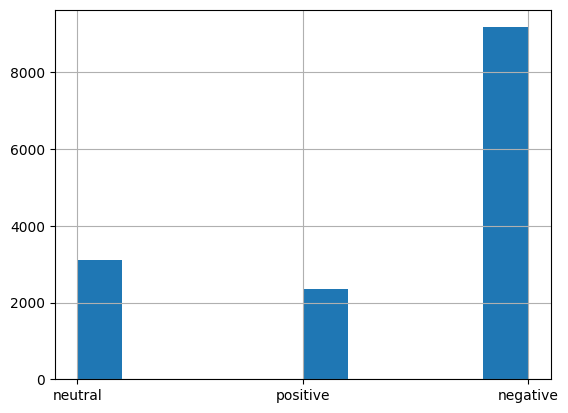

In [9]:
df['airline_sentiment'].hist()

In [10]:
target_map = {'positive': 1, 'negative': 0, 'neutral': 2}
df['target'] = df['airline_sentiment'].map(target_map)

**Most important is that needs to have column header named (sentence, label)**

In [11]:
df2 = df[['text', 'target']]
df2.columns = ['sentence', 'label']
df2.to_csv('data.csv', index=None)

In [12]:
!head data.csv

sentence,label
@VirginAmerica What @dhepburn said.,2
@VirginAmerica plus you've added commercials to the experience... tacky.,1
@VirginAmerica I didn't today... Must mean I need to take another trip!,2
"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
@VirginAmerica and it's a really big bad thing about it,0
"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA",0
"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",1
"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",2


In [13]:
from datasets import load_dataset
raw_dataset = load_dataset('csv', data_files='data.csv')

Generating train split: 0 examples [00:00, ? examples/s]

In [14]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [15]:
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=42)

In [16]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

In [17]:
# if you have multiple csv files
# load_dataset('csv', data_files=['file1.csv', 'file2.csv'])

In [18]:
# if you already have a train-test split:
# load_dataset(
#     'csv',
#     data_files={'train': ['train1.csv', 'train2.csv'],
#                 'test': 'test.csv'
#     }
# )

In [19]:
checkpoint = 'distilbert-base-cased'

In [20]:
from transformers import AutoTokenizer

In [21]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [22]:
def tokenize_fn(batch):
  return tokenizer(batch['sentence'], truncation=True)

In [23]:
tokenized_datasets = split.map(tokenize_fn, batched=True)

Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/4392 [00:00<?, ? examples/s]

In [24]:
from transformers import AutoModelForSequenceClassification, \
  Trainer, TrainingArguments

**Always check num_labels (in this case 3)**

In [25]:
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
!pip install torchinfo

In [27]:
from torchinfo import summary

In [28]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 65,783,811
Trainable params: 65,783,811
Non-trainable params: 0

In [29]:
training_args = TrainingArguments(
  output_dir='training_dir',
  evaluation_strategy='epoch',
  save_strategy='epoch',
  num_train_epochs=3,
  per_device_train_batch_size=16,
  per_device_eval_batch_size=64,
)

In [30]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average='macro')
  return {'accuracy': acc, 'f1': f1}

In [31]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [32]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.547400,0.455110,0.823998,0.765804
2,0.347600,0.469228,0.836749,0.774892
3,0.248700,0.615445,0.833106,0.776531


TrainOutput(global_step=1923, training_loss=0.3306847511327211, metrics={'train_runtime': 190.6876, 'train_samples_per_second': 161.227, 'train_steps_per_second': 10.085, 'total_flos': 388537948763424.0, 'train_loss': 0.3306847511327211, 'epoch': 3.0})

In [33]:
!ls training_dir

checkpoint-1282  checkpoint-1923  checkpoint-641  runs


In [34]:
from transformers import pipeline

In [35]:
savedmodel = pipeline('text-classification',
                      model='training_dir/checkpoint-1282',
                      device=0)

In [36]:
split['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 4392
})

In [37]:
test_pred = savedmodel(split['test']['sentence'])

In [38]:
test_pred

[{'label': 'LABEL_1', 'score': 0.9277132749557495},
 {'label': 'LABEL_1', 'score': 0.927291989326477},
 {'label': 'LABEL_1', 'score': 0.8631912469863892},
 {'label': 'LABEL_1', 'score': 0.7451472878456116},
 {'label': 'LABEL_2', 'score': 0.47148314118385315},
 {'label': 'LABEL_0', 'score': 0.9958609938621521},
 {'label': 'LABEL_2', 'score': 0.8285973072052002},
 {'label': 'LABEL_0', 'score': 0.8534660935401917},
 {'label': 'LABEL_1', 'score': 0.5521005392074585},
 {'label': 'LABEL_0', 'score': 0.9972345232963562},
 {'label': 'LABEL_0', 'score': 0.9479988813400269},
 {'label': 'LABEL_0', 'score': 0.9962835907936096},
 {'label': 'LABEL_1', 'score': 0.9464154243469238},
 {'label': 'LABEL_0', 'score': 0.9954255223274231},
 {'label': 'LABEL_2', 'score': 0.9844897985458374},
 {'label': 'LABEL_0', 'score': 0.39648962020874023},
 {'label': 'LABEL_0', 'score': 0.9492334723472595},
 {'label': 'LABEL_0', 'score': 0.9973733425140381},
 {'label': 'LABEL_0', 'score': 0.8597623109817505},
 {'label': 

In [39]:
def get_label(d):
  return int(d['label'].split('_')[1])

test_pred = [get_label(d) for d in test_pred]

In [40]:
print("acc:", accuracy_score(split['test']['label'], test_pred))

acc: 0.8367486338797814


In [41]:
print("f1:", f1_score(split['test']['label'], test_pred, average='macro'))

f1: 0.7748920058251989


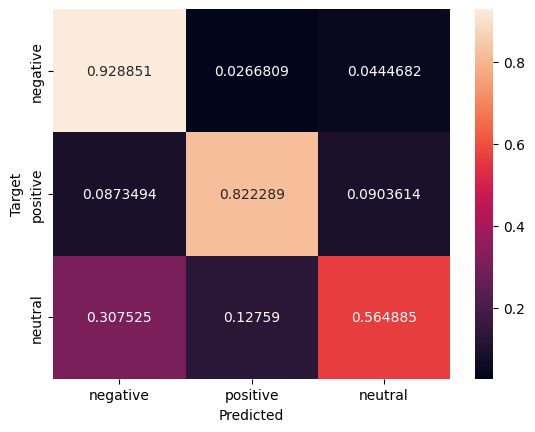

In [42]:
# Scikit-Learn is transitioning to V1 but it's not available on Colab
# The changes modify how confusion matrices are plotted
def plot_cm(cm):
  classes = ['negative', 'positive', 'neutral']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sn.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

cm = confusion_matrix(split['test']['label'], test_pred, normalize='true')
plot_cm(cm)